# Chapter 5: Wrangling and Feature Engineering

In this chapter we will cover:
- Define feature engineering
- Feature extraction
- Combining multiple variables
- Temporal and Spatial feature creation
- Contexualizing feature engineering
- Numerical encoding

---

Feature Engineering is that one component of the data science pipeline, which can offer a significant boost to the predictive abilities if the data is being fed to a machine learning algorithm for prediction task. It also strengthens the ability to see meaningful correlation of data points with each other. This may sound confusing for now but you'll realize how significant and challenging this step is. 

Feature Engineering is the step of manipulating existing featues or creating new ones out of the existing set of features. The raw data that we get, after clean up, has to be prepared in a form that is ready for statistical analysis and prediction. It also enables understanding the complex relation between variables. To illustrate how this creates value, suppose we have a computer-generated alpha-numeric customer ID for every customer who buys from an online store. If you were given the record of every customer purchase along with that customer ID field, without any further details, this column would just be a set of strings that won't make any sense to people interpreting this data or to any algorithm no matter how powerful it is for prediction. But if you later figure out, that the first 5 digits in each customer ID is the Zipcode of the customer's browsing address while making a purchase, you can create a new feature of current zipcode and probably start finding patterns of how location affects purchase on the online store. 

The point of going through the example above was to tell that some columns might contain concealed information that, if revealed in form of another feature, can provide more predictive capability then just a set of strings that make no sense on its own. Similarly, feature engineering also involves creating combination of features into a new one. In a social impact analysis setting, as we will see in our guided practice ahead, it will make more sense to use hit-rate (created by dividing the sum of searches with contraband found for a race in a beat by the total population of a race in that beat) for analyzing presence of police discrimination than just using the sum of searches with contraband found alone.

*The image below shows how featurizing an image can make image segmentation simple*

![An image](https://www.researchgate.net/profile/Bruno-Artacho/publication/337771814/figure/fig1/AS:832806989074433@1575568067583/Semantic-segmentation-examples-using-WASPnet.ppm)

Some more examples of useful feature engineering practices include converting datetime stamps to a set of temporal features such as whether it was a weekend or a feature that indicates if a time is within commuting hours. As you can imagine that sometimes just datetime stamp might not be a good predictive feature but by understanding it with context to certain temporal features, we can get a more clear relation between data points. This also holds for geospatial features where latitude/longitude points can be converted to features like distance from the city center or distance from sea. In such example we are converting raw features to a set that has more relevance to our analysis.

Additionally, as we have been discussing this throughout, the context of the problem can give us idea about what features we can think about creating from the existing set. One example related to our guiden project comes from a study that wanted to conduct the traffic stop analysis for cars during the intertwilight period (period around sunset). This means creating an indicator variable that searches for that period from the timestamp and set itself to True if it is in the intertwilight period. Therefore, enabling the researchers to contrast between the study for both intertwilight periods and ones beyond these times.

Another set of feature engineering component is encoding. We already glimpsed through this topic in the previous chapter. Encoding referes to converting values in a column to numeric data type. A prime value of doing this operation is that most analytical tools and machine learning algorithms that would work with your data, perform with numbers (the inherent language that computers understand) and might not even work with strings or objects. As a result, it is useful to encode variables with string categories to numbers. However, another catch with that is that these algorithms could take the numerical encoding to their real values, for eg. a number assigned to model of the car can give the models' ranking whereas these rankings have no impact on our analysis and can create a meaningless correlation. To deal with such a case, such values can be one-hot encoded, which refers to creating an indicator variable for each category of the column. We will see more examples of this in the guided practice ahead.

### Guided Practice

In the following blocks, we are going to practice generation of new features. We will continue with the case study of traffic stops data in Chicago. Also notice that instead of importing a csv file, we will import a pickle object to keep the data types the dataframe had.

In [1]:
# replace csv and import pickle
import pandas as pd
stops_filtered = pd.read_pickle('stops_filtered.pkl')

The first task we are going to perform is to create a new variable called 'ContraORDrugs' which sets itself to True if either a contraband item or a weapon is found in the vehicle.

We will use pandas `where` method which checks for a condition in the first argument and then uses the second argument to assign it to the vaariable in case it is false. The simplified structure therefore is:<br>
`df.where(condition, B)`
<br>`B` above is the value if the condition is False

In [2]:
# Combine Contraband and weapon
stops_filtered['ContraORDrugs'] = True
stops_filtered['ContraORDrugs'] = \
stops_filtered['ContraORDrugs'].where((stops_filtered['VEHCONTRA']==1) | (stops_filtered['VEHDRUGS']==1), False)

In [3]:
# Checking proportion of a stop having either Contraband or Drugs 
stops_filtered['ContraORDrugs'].value_counts()

False    116396
True        445
Name: ContraORDrugs, dtype: int64

We can verify if our function worked correctly by checking in a random sample of rows among all the rows where **ContraORDrugs** is true and compare if either 'VEHCONTRA' or 'VEHDRUGS' is 1. You don't need to worry much about the code below. In case you're curious, see the comments. You can run this cell multiple times to see if it holds true for every randomly generated set of indices.

In [4]:
import random
# Generating a list of 15 randmonly selected row indices where 'ContraORDrugs' is True
index_lst = random.sample(sorted(stops_filtered[stops_filtered['ContraORDrugs']==1].index), 15)
# Now pulling in all the rows that were selected by the line above and subsetting the dataframe to show 3 columns
stops_filtered.loc[index_lst][['ContraORDrugs','VEHCONTRA','VEHDRUGS']]

,ContraORDrugs,VEHCONTRA,VEHDRUGS
340093,True,1,1
243357,True,1,2
149263,True,1,1
289463,True,1,1
9539,True,1,2
94641,True,1,1
292214,True,1,2
9579,True,1,1
196203,True,1,1
240701,True,1,2


Before moving to the next major task, we will produce a line-plot of the DATESTOP vaiable once again to observe the pattern of stops everyday. What do you notice from the plot below?

<AxesSubplot:xlabel='DATESTOP', ylabel='DURATION'>

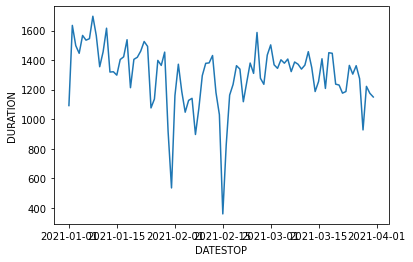

In [5]:
# plot
import seaborn as sns
stops_group = stops_filtered.groupby('DATESTOP').count()
sns.lineplot(data = stops_group, x = 'DATESTOP', y = 'DURATION')

As you can see, there is a cyclic pattern every week which seem to dip over weekends and rise again on weekdays. We will now create an indicator variable to mark if the stop happened during a weekday. Pandas offers us a function to do that which converts any pandas datetime datatype to the day of the week. This way we can take out weekday as a key variable to compare the occurence of a stop with.

In [6]:
# Create temporal weekend/weekday feature
stops_filtered['Weekday'] = stops_filtered['DATESTOP'].dt.weekday

In [7]:
# Use pandas where to classify if the day is a weekend
# Note: According to the documentation, Monday = 0, Sunday = 6
stops_filtered['IsWeekend'] = True
stops_filtered['IsWeekend'] = \
stops_filtered['IsWeekend'].where((stops_filtered['Weekday']==5) | (stops_filtered['Weekday']==6), False)

In [8]:
stops_filtered['IsWeekend'].value_counts()

False    84182
True     32659
Name: IsWeekend, dtype: int64

<AxesSubplot:xlabel='DATESTOP', ylabel='DURATION'>

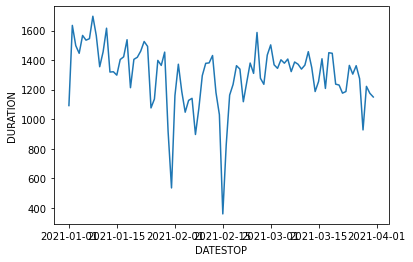

In [9]:
# Add visual for the thing above (before & after)
stops_group = stops_filtered.groupby('DATESTOP').count()
sns.lineplot(data = stops_group, x = 'DATESTOP', y = 'DURATION')

With the histogram above, we can see a clear pattern bewteend the weekend and weekdays an this gives us a predictible feature which can help us in estimate number of stops over a particular day.

We discussed that statistical tools and plots usually deal with numerical categories as integers and treat such variables as they are ranked, unless those numbers are defined as strings (objects) or categories. Even in such a scenario, some models will give out an error when working with discrete categories as they only require numbers or booleans. For some variables in our dataset with categories set in the range from 0 till 2, we will convert them to indicator variables. 

Consider the catefory VEHDRUGS which has 0 if Search wasn't conducted, 1 if Drugs were found and 2 if Drugs weren't found. To convert them to features that are compatible with models, we will first create an indicator variable for if Search was conducted for Drugs (All rows will either 1 or 2 will be True) and then another indicator for stops where drugs were found (rows with value 1). This then also covers every possible case. For eg. if search was conducted but drugs weren't found, the search column will be True and the Drugs column will be False. We will again use Pandas where method.

In [10]:
# Setting default state
stops_filtered['DrugsFound'] = True
# Remember, inplace=True performs the operation in place in data
stops_filtered['DrugsFound'].where(stops_filtered['VEHDRUGS'] == 1, False, inplace=True)

In [11]:
# Similarly we'll repeat the operation for if Weapons were found
stops_filtered['WeaponsFound'] = True
stops_filtered['WeaponsFound'].where(stops_filtered['VEHWEAP'] == 1, False, inplace=True)

In [12]:
# View the head of the columns. Most the values are fault as we'll notice
stops_filtered[['DrugsFound','WeaponsFound']].head()

,DrugsFound,WeaponsFound
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In the part below we will look at an important function in Pandas that is used very frequently in data wrangling operations. Groupby allows us to create a Pandas Group DataFrame which, according to the documentation, involves some combination of splitting the object, applying a function, and combining the results. We will see how it works below.

Our primary concer in this entire project is to see how police beahvious in stops differ for every race in order to identify existence of racial bias. For that it'll be useful to have an aggregate look on all activities performed during a stop for each race. This won't indicate a causal relation but will show us a pattern.

In [13]:
# Create a Group dataframe
stops_grouped = stops_filtered.groupby(['DRRACE'])
# If you print it it will only show you the object type
stops_grouped

In [14]:
# Aggregate dataframe using mean and subset Duration 
stops_grouped.mean()['DURATION']

DRRACE
1    7.453721
2    8.083024
3    6.625835
4    7.187564
5    6.660507
6    8.310714
Name: DURATION, dtype: float64

In [15]:
# Aggregate dataframe using sum and subset WeaponsFound and DrugsFound
stops_grouped.sum()[['WeaponsFound', 'DrugsFound']]
# Notice, for boolean values you get a count of all rows that were True when you apply sum()

,WeaponsFound,DrugsFound
DRRACE,,
1,3,17
2,47,219
3,0,1
4,5,77
5,0,3
6,0,0


Continuing from creation of indicator features, for variables with multiple categories, we would have to create a new column for each category in the variable. This is called one-hot encoding. To identify each race, we will have to create a variable indicating each race (or known as a dummy variable). To state it again, the reason for doing is that most models only accept integer or boolean. We don't won't integer here to prevent getting each category ranked and evaluated as so. Pandas get_dummies() will enable us to create these dummy variables.

In [16]:
# One-hot encode DRRACE
stops_filtered['DRRACE'].astype('category')
stops_filtered = pd.get_dummies(stops_filtered, columns = ['DRRACE'])

In [17]:
# scroll to the end to view the newly created variables. 
# Also note that by default get_dummies() removes the original variable 'DRRACE'
stops_filtered.head()

,DATESTOP,TIMESTOP,DURATION,CITY_I,STATE,RESSTOP,TYPEMOV,BEAT_I,VEHSRCHCOND,VEHCONTRA,...,Weekday,IsWeekend,DrugsFound,WeaponsFound,DRRACE_1,DRRACE_2,DRRACE_3,DRRACE_4,DRRACE_5,DRRACE_6
0,2021-01-01,0:33,5,CHICAGO,IL,3,NaN,1234,2,0,...,4,False,False,False,0,0,0,1,0,0
1,2021-01-01,1:50,4,CHICAGO,IL,3,NaN,1122,2,0,...,4,False,False,False,0,1,0,0,0,0
2,2021-01-01,8:50,4,CHICAGO,IL,3,NaN,332,2,0,...,4,False,False,False,0,1,0,0,0,0
3,2021-01-01,12:41,6,CHICAGO,IL,3,NaN,1121,2,0,...,4,False,False,False,0,1,0,0,0,0
4,2021-01-01,13:51,5,CHICAGO,IL,3,NaN,423,2,0,...,4,False,False,False,0,1,0,0,0,0


### Exercise

In [19]:
# Create a temporal feature for hour of the day from 0-23

In [25]:
# Plot a graph showing frequency of stops for each hour 

In [20]:
# One-hot-encode TypeMOV and RESTOP variables

In [23]:
# Create Boolean feauures for 'VEHSTOLPROP' and 'VEHSRCHCOND'

In [24]:
# Groupby the dataframe by beat and display mean duration for first 10 beats

In [26]:
# Plot a graph showing boxplots of duration for these 10 beats